# Data preprocessing

In [1]:
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from sklearn.utils import shuffle

df = pd.read_csv('sample/Data_Entry_2017.csv')

diseases = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']
#Number diseases
for disease in diseases :
    df[disease] = df['Finding Labels'].apply(lambda x: 1 if disease in x else 0)
    
#remove Y after age
df['Age']=df['Patient Age'].apply(lambda x: x[:-1]).astype(int)
df['Age Type']=df['Patient Age'].apply(lambda x: x[-1:])
df.loc[df['Age Type']=='M',['Age']] = df[df['Age Type']=='M']['Age'].apply(lambda x: round(x/12.)).astype(int)
df.loc[df['Age Type']=='D',['Age']] = df[df['Age Type']=='D']['Age'].apply(lambda x: round(x/365.)).astype(int)
# remove outliers
df = df.drop(df['Age'].sort_values(ascending=False).head(16).index)
df['Age'] = df['Age']/df['Age'].max()

#one hot data
# df = df.drop(df.index[4242])
df = df.join(pd.get_dummies(df['Patient Gender']))
df = df.join(pd.get_dummies(df['View Position']))

#random samples
df = shuffle(df)

#get other data
data = df[['Age', 'F', 'M', 'AP', 'PA']]
data = np.array(data)

labels = df[diseases].as_matrix()
files_list = ('sample/images/' + df['Image Index']).tolist()

# #test to perfect
# labelB = df['Emphysema'].tolist()

labelB = (df[diseases].sum(axis=1)>0).tolist()
labelB = np.array(labelB, dtype=int)

In the call bellow, I load, convert images to numpy array and split dataset to training, validation and testing

In [2]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path, shape):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, grayscale=True, target_size=shape)
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 1)
    x = image.img_to_array(img)/255
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 1) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths, shape):
    list_of_tensors = [path_to_tensor(img_path, shape) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

train_labels = labelB[:89600][:, np.newaxis]
valid_labels = labelB[89600:100800][:, np.newaxis]
test_labels = labelB[100800:][:, np.newaxis]

train_data = data[:89600]
valid_data = data[89600:100800]
test_data = data[100800:]

img_shape = (64, 64)
train_tensors = paths_to_tensor(files_list[:89600], shape = img_shape)
valid_tensors = paths_to_tensor(files_list[89600:100800], shape = img_shape)
test_tensors = paths_to_tensor(files_list[100800:], shape = img_shape)

Using TensorFlow backend.
/home/aind2/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
100%|██████████| 11304/11304 [02:27<00:00, 76.46it/s]


Convert label from 1D to 2D

In [3]:
def onhotLabels(label):
    from sklearn.preprocessing import OneHotEncoder
    enc = OneHotEncoder()
    enc.fit(label)
    return enc.transform(label).toarray()

train_labels = onhotLabels(train_labels)
valid_labels = onhotLabels(valid_labels)
test_labels = onhotLabels(test_labels)

# CapsNet model

In [4]:
import os
import argparse
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks

import numpy as np
from keras import layers, models, optimizers
from keras import backend as K
import matplotlib.pyplot as plt
from PIL import Image
from capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask

def CapsNet(input_shape, n_class, routings):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 3d, [width, height, channels]
    :param n_class: number of classes
    :param routings: number of routing iterations
    :return: Two Keras Models, the first one used for training, and the second one for evaluation.
            `eval_model` can also be used for training.
    """
    x = layers.Input(shape=input_shape)

    # Layer 1: Just a conventional Conv2D layer
    conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=2, padding='same', activation='relu', name='conv1')(x)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
    primarycaps = PrimaryCap(conv1, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='same')

    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings,
                             name='digitcaps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='capsnet')(digitcaps)

    # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked_by_y = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer. For training
    masked = Mask()(digitcaps)  # Mask using the capsule with maximal length. For prediction

    # Shared Decoder model in training and prediction
    decoder = models.Sequential(name='decoder')
    decoder.add(layers.Dense(512, activation='relu', input_dim=16*n_class))
    decoder.add(layers.Dense(1024, activation='relu'))
    decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
    decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

    # Models for training and evaluation (prediction)
    train_model = models.Model([x, y], [out_caps, decoder(masked_by_y)])
    eval_model = models.Model(x, [out_caps, decoder(masked)])

    # manipulate model
    noise = layers.Input(shape=(n_class, 16))
    noised_digitcaps = layers.Add()([digitcaps, noise])
    masked_noised_y = Mask()([noised_digitcaps, y])
    manipulate_model = models.Model([x, y, noise], decoder(masked_noised_y))
    return train_model, eval_model, manipulate_model

model, eval_model, manipulate_model = CapsNet(input_shape=train_tensors.shape[1:],
                                                  n_class=len(np.unique(train_labels)),
                                                  routings=4)

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 64, 64, 1)     0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 32, 32, 256)   20992       input_1[0][0]                    
____________________________________________________________________________________________________
primarycap_conv2d (Conv2D)       (None, 16, 16, 256)   5308672     conv1[0][0]                      
____________________________________________________________________________________________________
primarycap_reshape (Reshape)     (None, 8192, 8)       0           primarycap_conv2d[0][0]          
___________________________________________________________________________________________

I implement custom matrics for evaluation

In [5]:
from keras import backend as K

def binary_accuracy(y_true, y_pred):
    y_true, y_pred = K.cast(K.argmax(y_true, axis=1), K.floatx()), K.cast(K.argmax(y_pred, axis=1), K.floatx())
    return K.mean(K.equal(y_true, K.round(y_pred)))

def precision_threshold(threshold = 0.5):
    def precision(y_true, y_pred):
        y_true, y_pred = K.cast(K.argmax(y_true, axis=1), K.floatx()), K.cast(K.argmax(y_pred, axis=1), K.floatx())
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(y_pred)
        precision_ratio = true_positives / (predicted_positives + K.epsilon())
        return precision_ratio
    return precision

def recall_threshold(threshold = 0.5):
    def recall(y_true, y_pred):
        y_true, y_pred = K.cast(K.argmax(y_true, axis=1), K.floatx()), K.cast(K.argmax(y_pred, axis=1), K.floatx())
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.clip(y_true, 0, 1))
        recall_ratio = true_positives / (possible_positives + K.epsilon())
        return recall_ratio
    return recall

def fbeta_score_threshold(beta = 1, threshold = 0.5):
    def fbeta_score(y_true, y_pred):
        threshold_value = threshold
        beta_value = beta
        p = precision_threshold(threshold_value)(y_true, y_pred)
        r = recall_threshold(threshold_value)(y_true, y_pred)
        bb = beta_value ** 2
        fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
        return fbeta_score
    return fbeta_score

In [6]:
def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

def train(model, data, lr, lr_decay, lam_recon, batch_size, shift_fraction, epochs):
    """
    Training a CapsuleNet
    :param model: the CapsuleNet model
    :param data: a tuple containing training and testing data, like `((x_train, y_train), (x_test, y_test))`
    :param args: arguments
    :return: The trained model
    """
    # unpacking the data
    (x_train, y_train), (x_test, y_test) = data

    # callbacks
    log = callbacks.CSVLogger('saved_models/CapsNet_log.csv')
    tb = callbacks.TensorBoard(log_dir='saved_models/tensorboard-logs',
                               batch_size=batch_size, histogram_freq=0)
    checkpoint = callbacks.ModelCheckpoint(filepath='saved_models/CapsNet.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)
    cb_lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: lr * (lr_decay ** epoch))

    # compile the model
    model.compile(optimizer='sgd', loss='binary_crossentropy', 
              metrics=[precision_threshold(threshold = 0.5), 
                      recall_threshold(threshold = 0.5), 
                      fbeta_score_threshold(beta=0.5, threshold = 0.5),
                      binary_accuracy])

    # Training without data augmentation:
#     model.fit([x_train, y_train], [y_train, x_train], batch_size=batch_size, epochs=epochs,
#               validation_data=[[x_test, y_test], [y_test, x_test]], callbacks=[log, tb, checkpoint, cb_lr_decay])

    # Begin: Training with data augmentation ---------------------------------------------------------------------#
    def train_generator(x, y, batch_size, shift_fraction=0.):
        train_datagen = ImageDataGenerator(width_shift_range=shift_fraction,
                                           height_shift_range=shift_fraction)  # shift up to 2 pixel for MNIST
        generator = train_datagen.flow(x, y, batch_size=batch_size)
        while 1:
            x_batch, y_batch = generator.next()
            yield ([x_batch, y_batch], [y_batch, x_batch])

    # Training with data augmentation. If shift_fraction=0., also no augmentation.
    model.fit_generator(generator=train_generator(x_train, y_train, batch_size, shift_fraction),
                        steps_per_epoch=int(y_train.shape[0] / batch_size),
                        epochs=epochs,
                        validation_data=[[x_test, y_test], [y_test, x_test]],
                        callbacks=[log, tb, checkpoint, cb_lr_decay])
    # End: Training with data augmentation -----------------------------------------------------------------------#

    from utils import plot_log
    plot_log('saved_models/CapsNet_log.csv', show=True)

    return model

Epoch 1/20
2800/2800 [==============================] - 856s - loss: 1.3833 - capsnet_loss: 0.6901 - decoder_loss: 0.6932 - capsnet_precision: 0.4935 - capsnet_recall: 0.2591 - capsnet_fbeta_score: 0.3792 - capsnet_binary_accuracy: 0.5758 - decoder_precision: 0.9667 - decoder_recall: 0.9915 - decoder_fbeta_score: 0.9715 - decoder_binary_accuracy: 0.0174 - val_loss: 1.3611 - val_capsnet_loss: 0.6679 - val_decoder_loss: 0.6931 - val_capsnet_precision: 0.6246 - val_capsnet_recall: 0.3468 - val_capsnet_fbeta_score: 0.5231 - val_capsnet_binary_accuracy: 0.6002 - val_decoder_precision: 0.9591 - val_decoder_recall: 0.9914 - val_decoder_fbeta_score: 0.9654 - val_decoder_binary_accuracy: 0.0164
Epoch 2/20
2800/2800 [==============================] - 859s - loss: 1.3615 - capsnet_loss: 0.6684 - decoder_loss: 0.6931 - capsnet_precision: 0.6013 - capsnet_recall: 0.4277 - capsnet_fbeta_score: 0.5392 - capsnet_binary_accuracy: 0.6023 - decoder_precision: 0.9665 - decoder_recall: 0.9905 - decoder_fbe

2800/2800 [==============================] - 854s - loss: 1.3497 - capsnet_loss: 0.6566 - decoder_loss: 0.6930 - capsnet_precision: 0.6056 - capsnet_recall: 0.4854 - capsnet_fbeta_score: 0.5678 - capsnet_binary_accuracy: 0.6161 - decoder_precision: 0.9666 - decoder_recall: 0.9956 - decoder_fbeta_score: 0.9722 - decoder_binary_accuracy: 0.0219 - val_loss: 1.3459 - val_capsnet_loss: 0.6529 - val_decoder_loss: 0.6930 - val_capsnet_precision: 0.6253 - val_capsnet_recall: 0.4580 - val_capsnet_fbeta_score: 0.5727 - val_capsnet_binary_accuracy: 0.6220 - val_decoder_precision: 0.9594 - val_decoder_recall: 0.9962 - val_decoder_fbeta_score: 0.9665 - val_decoder_binary_accuracy: 0.0223
Epoch 16/20
2800/2800 [==============================] - 854s - loss: 1.3495 - capsnet_loss: 0.6565 - decoder_loss: 0.6930 - capsnet_precision: 0.6059 - capsnet_recall: 0.4849 - capsnet_fbeta_score: 0.5692 - capsnet_binary_accuracy: 0.6167 - decoder_precision: 0.9669 - decoder_recall: 0.9962 - decoder_fbeta_score: 

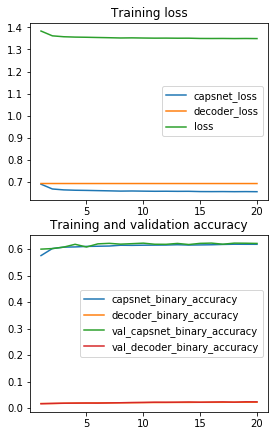

In [7]:
train(model=model, data=((train_tensors, train_labels), (valid_tensors, valid_labels)), 
      lr=0.001, lr_decay=0.9, lam_recon=0.392, batch_size=32, shift_fraction=0.1, epochs=20)

# Testing

In [8]:
model.load_weights('saved_models/CapsNet.best.from_scratch.hdf5')
prediction = eval_model.predict(test_tensors)

In [11]:
threshold = 0.5
beta = 0.5

pre = K.eval(precision_threshold(threshold = threshold)(K.variable(value=test_labels),
                                   K.variable(value=prediction[0])))
rec = K.eval(recall_threshold(threshold = threshold)(K.variable(value=test_labels),
                                   K.variable(value=prediction[0])))
fsc = K.eval(fbeta_score_threshold(beta = beta, threshold = threshold)(K.variable(value=test_labels),
                                   K.variable(value=prediction[0])))

print ("Precision: %f %%\nRecall: %f %%\nFscore: %f %%"% (pre, rec, fsc))

Precision: 0.625410 %
Recall: 0.473513 %
Fscore: 0.587705 %


In [12]:
K.eval(binary_accuracy(K.variable(value=test_labels),
                                   K.variable(value=prediction[0])))

0.62526542